In [ ]:
! pip install -q kaggle
! pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 12.2 MB/s eta 0:00:00


In [ ]:
#!pip3 install -U torch torchvision torchaudio
!pip3 install -U fastai==2.2.0

In [ ]:
from fastai.vision.all import *

In [ ]:
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

In [ ]:
# This notebook runs on colab , if u want to run it on kaggle , dont run the following and change the file paths 
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c Multiclass-segmentation

 99% 372M/374M [00:09<00:00, 43.7MB/s]
100% 374M/374M [00:09<00:00, 40.9MB/s]


In [ ]:
!unzip /content/Multiclass-segmentation.zip -d /content/alldataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

def decode_rle_to_mask(rle, height, width, class_id, viz=False):
    '''
    rle : run-length as string formated (start value, count)
    height : height of the mask 
    width : width of the mask
    class_id : class ID for the mask
    returns binary mask
    '''
    rle = np.array(rle.split(' ')).reshape(-1, 2)
    mask = np.zeros((height*width, 1, 3))
    if viz:
        color = np.random.rand(3)
    else:
        color = [class_id, class_id, class_id]
    for i in rle:
        mask[int(i[0]):int(i[0])+int(i[1]), :, :] = color

    return mask.reshape(height, width, 3)
    
train_csv = pd.read_csv("/content/alldataset/train.csv")

# create 
grouped = train_csv.groupby(['ImageName', 'ClassNumber']).agg({'ImageHeight': 'first', 'ImageWidth': 'first', 'Encoding': lambda x: x.tolist()})

result = {}

for (name, class_id), height, width, encodings in grouped.itertuples():
    masks = [decode_rle_to_mask(encoding,height ,width, class_id)[:,:,0] for encoding in encodings]
    mixed_mask = sum([i * (idx+1) for idx, i in enumerate(masks)])
    if name in result:
        result[name] += mixed_mask
    else:
        result[name] = mixed_mask

In [ ]:
result = list(result.items())

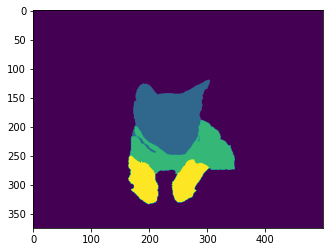

In [ ]:
plt.imshow(result[0][1])

In [ ]:
#os.mkdir("/kaggle/working/labels")
#for item in tqdm(result):
#     plt.imsave("/kaggle/working/labels/" + item[0] + '_P' + ".png" , cv2.resize(item[3] , (224 , 224) , interpolation = cv2.INTER_NEAREST))

In [ ]:
codes_list = ["VOID" , "HEAD" , "BODY" , "HANDS" , "TAIL"]
with open("/content/alldataset/codes.txt", "w") as f:
    for item in codes_list:
        f.write("%s\n" % item)

In [ ]:
path = Path("/content/alldataset")

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['VOID', 'HEAD', 'BODY', 'HANDS', 'TAIL'], dtype='<U5')

In [ ]:
# get list of models that start with se
import timm
efficient_nets = [model for model in timm.list_models(pretrained=True) if model.startswith('convnext')]
efficient_nets

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [ ]:
name2id = {'VOID': 0, 'HEAD': 1, 'BODY': 2, 'HANDS': 3 , "TAIL":4}

In [ ]:
void_code = name2id['VOID']

In [ ]:
void_code

0

In [ ]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [ ]:
opt = ranger

In [ ]:
import albumentations as A

def Album_batchtfms(): 
    #TODO : Remove bad augmentations by trial and error
    return A.Compose([
    A.CoarseDropout(p=0.3),
    A.GaussNoise(),
    A.RandomBrightnessContrast(p=0.3),
    A.RandomGamma(p=0.3),
    A.CLAHE(p=0.3),
    A.Flip(0.3)
])
    
    
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

def make_dataloaders_from_numpy_data( image , label  , bs = 16 ):
    def pass_index(idx):
        return idx

    def get_x(i):
        # NOTE: This is a grayscale image that appears to just work with a network expecting RGB.
        # I suspect this is due to tensor broadcasting rules.
        return plt.imread("/content/alldataset/TrainImages/" + image[i][0] + ".jpg")

    def get_y(i):
        return label[i][1]
    
    dblock = DataBlock((ImageBlock,MaskBlock(codes)),
                get_items=pass_index,
                get_x = get_x,
                get_y=get_y,
                splitter=RandomSplitter(valid_pct=0.3),
                item_tfms=[Resize((350,350) , method='squish')],
                batch_tfms = AlbumentationsTransform(Album_batchtfms()))
        
    num_images = len(image)
    dls = dblock.dataloaders(list(range(num_images)) , bs=bs )

    return dls

In [ ]:
dls = make_dataloaders_from_numpy_data(result, result)

In [ ]:
def IoU_f(preds:Tensor, targs:Tensor, eps:float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value 
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]
    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]
        
        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()   # find mean of class IoU values
    return iou

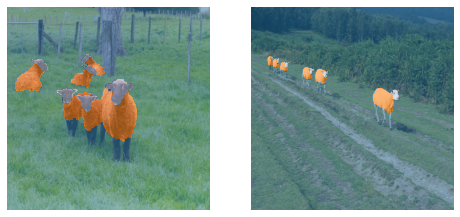

In [ ]:
dls.show_batch(max_n=2, vmin=0, vmax=20 , figsize = (8,8))

In [ ]:
weights = torch.tensor([[0.5] + [0.7] + [1.1] + [0.7] + [0.6]]).cuda()

In [ ]:
from timm.models.resnet import resnet34
learn = unet_learner(dls, resnet34, metrics=[IoU_f , acc_camvid], self_attention = True, act_cls = Mish, opt_func=opt , loss_func = CrossEntropyLossFlat(weight=weights, axis=1) ).to_fp16()

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.05754399299621582)

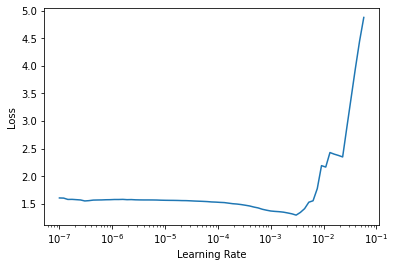

In [ ]:
learn.lr_find() # Choose here the lr that gets loss decreasing , dont choose the minimum as it could get u to overfit , please refer to the paper 

In [ ]:
cbs = [
      GradientAccumulation(128),
      SaveModelCallback(monitor = "IoU_f" ),
      ]

In [ ]:
lr = 1e-3
learn.fit_flat_cos(8, slice(lr) , cbs= cbs)

In [ ]:
# reduce bs from 128 to 16 and keep training got us the best score.
cbs = [
      GradientAccumulation(16),
      SaveModelCallback(monitor = "IoU_f" ),
      ]

lr = 1e-3
learn.fit_flat_cos(8, slice(lr) , cbs= cbs)

In [ ]:
lrs = slice(1e-3/400, 1e-3/4) 

In [ ]:
lrs

slice(2.5e-06, 0.00025, None)

In [ ]:
learn.unfreeze()

In [ ]:
lr = 1e-3
learn.fit_flat_cos(8, slice(lr) , cbs= cbs)

In [ ]:
# original expirement was to reduce bs from 128 --> 16 but this is another one we tried and got smaller score
bs = 128

while bs != 8 :
  cbs = [
      GradientAccumulation(bs),
      SaveModelCallback(monitor = "IoU_f" ),
      ]
  lr = 1e-3
  learn.fit_flat_cos(4, slice(lr) , cbs= cbs)
  bs /= 2

In [ ]:
learn.show_results(max_n = 4, figsize = (12,6) , vmin = 0, vmax = 10)

In [ ]:
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
# The following is just preparing the submission file

In [ ]:
ss = pd.read_csv("/content/alldataset/Sample Submission.csv")
tst_files = get_image_files("/content/alldataset/TestImages").sorted()
tst_dl = dls.test_dl(tst_files).to("cuda")

In [ ]:
sizes = []
for indx , i in enumerate(tst_files):
  sizes.append((plt.imread(i).shape , str(tst_files[indx]).split("/")[-1] ))

In [ ]:
num_classes = 5
results = []

from tqdm import tqdm
import gc

for img_path , img_size in zip(tst_files , sizes):
    mixed_mask , _ , _ = learn.predict(img_path)
    resized = cv2.resize(mixed_mask.numpy(), (img_size[0][1], img_size[0][0]), 0, 0, interpolation=cv2.INTER_NEAREST)

    # Create a binary mask for each class label

    binary_masks = []
    is_zero_mask = True
    for class_label in range(1, 5): # loop only through 1 to 4 class labels
        binary_mask = np.where(resized == class_label, 1, 0).astype(np.uint8)
        if encode_mask_to_rle(binary_mask) != '':
            binary_masks.append(encode_mask_to_rle(binary_mask))
            is_zero_mask = False
    if is_zero_mask : # if all class labels are zeros, save the background instead
        print("###########################################################################")
        background_mask = np.where(resized == 0, 1, 0).astype(np.uint8)
        print("Background mask :" , background_mask)
        print(img_path ,background_mask.shape , background_mask.max())
        print("Mask:")
        print(encode_mask_to_rle(background_mask))
        binary_masks.append(encode_mask_to_rle(background_mask))

    results.append((binary_masks, img_size[1]))

In [ ]:
df1 = pd.DataFrame(columns=["ImageName" , "Encoding"])

In [ ]:
def m(x):
  if x.startswith("0"):
    return x[1:]
  else :
    return x

In [ ]:
for masks , img_name in results:
    for mask in masks:
      new_row = {'ImageName': img_name, 'Encoding': mask}
      df1 = df1.append(new_row, ignore_index=True)

In [ ]:
df1['ImageName']=df1['ImageName'].apply(m)

In [ ]:
df1['ImageName'] = df1['ImageName'].apply(lambda x: x[:-4])

In [ ]:
df1.to_csv("xsub.csv" , index=False)

In [ ]:
df1

In [ ]:
# learn2 = unet_learner(dls, resnet34, metrics=[IoU_f , acc_camvid], self_attention=True, act_cls=Mish, opt_func=opt)
# learn2.model.load_state_dict(torch.load("/content/drive/MyDrive/NUAIH MODELS/model.pth", map_location="cuda:0"))

<All keys matched successfully>